EPITA 2021 IML lab02_clustering_02-color-quantization v2023-03-27_103405 by G. Tochon & J. Chazalon

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Lab 2, part 2: Color quantization using clustering

Color quantization in another useful trick in image processing which is usually performed using clustering.
This is a good example of [vector quantization](https://en.wikipedia.org/wiki/K-means_clustering#Vector_quantization), and has direct application to compression.

So, here we will use clutering techniques to automatically discover the best [color palette](https://en.wikipedia.org/wiki/Palette_(computing)) for an image to compress it using [color indexing](https://en.wikipedia.org/wiki/Indexed_color), after applying [color quantization](https://en.wikipedia.org/wiki/Color_quantization) to reduce the number of colors.

### More about indexed colors
With RBG encoding, images have $255*255*255$ possible pixel colors. Obviously **only a fraction of those values is actually used.**

The following images illustrate the colors which are actually used in the images as a palette under them.

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img src='img/IndexedColorSample_(Caerulea3_crop).png' style='float: left; margin-right: 20px'>
<img src='img/IndexedColorSample_(Lapis.elephant.800pix.060203).png' style='float: left; margin-right: 20px'>
<img src='img/IndexedColorSample_(Lemon).png' style='float: left; margin-right: 20px'>
<img src='img/IndexedColorSample_(Strawberries_picked).png' style='float: left; margin-right: 20px'>
</div>

We can efficiently encode (before any block compression technique) the values using a lookup table (a *color palette*) as illustrated below:
<img src='img/Indexed_palette.png' style='width: 500px'>

This is very powerful: we needed $3*8*W*H$ bits to store the data, and now we need only $2*W*H+C*3*8$ bits, $W$ and $H$ being the width and heigth of the image, and $C$ being the actual number of colors.


### More about color compression
As only of fraction of the colors represented in the images are actually perceptible by our eyes/brain, we can cheat and reduce the colors to a subset of disctinct colors, as illustrated in the figure below that you will re-generate in the part of the lab session: you can see that 16 colors may be sufficient for most purposes of this image.
![](img/color-reduction.png)


### What's the trick?
The process we will follow is faily simple: 

1. first we will compute a clustering of all pixels in the color space (to identify the "high density" area, i.e. colors with many representatives);
2. then we will simplify the image by assigning to each pixel the color of its closest centroid (in the color space).

### Outline
In this part, we will:
- visualize image channel and color space
- cluster image colors
- visualize cluster boundaries
- recolor an image
- try different palette sizes

## 0. Setup

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import skimage as ski
import skimage.io as skio

### Data loading

We will play with the image from the Wikipedia page about [K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering#Vector_quantization). We will reproduce the illustrations.

In [2]:
img = skio.imread("data/Rosa_Gold_Glow_2_small_noblue.png")
img.shape, img.dtype

((196, 200, 3), dtype('uint8'))

In [3]:
# number of pixels
np.prod(img.shape[:3])

117600

## 1. Color analysis

Start by plotting the channels.

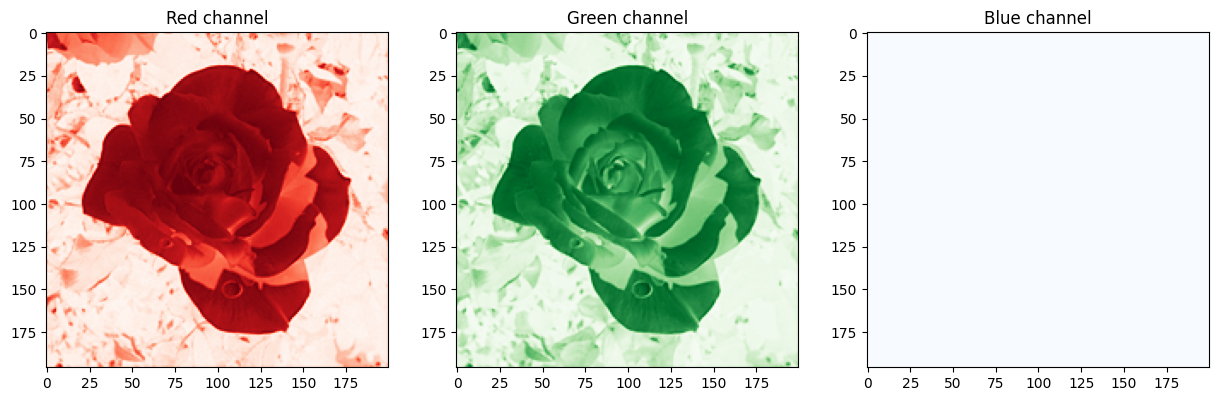

In [4]:
plt.figure(figsize=(15,5))
for cc, name in enumerate(["Red", "Green", "Blue"]):
    plt.subplot(1,3,cc+1)
    plt.imshow(img[...,cc], cmap=name+"s")
    plt.title(f"{name} channel")

We can notice that this image has no blue channel: this is very convenient to plot the color space in 2D!

Let us then plot all pixel colors in a Red/Green colorspace.

In [5]:
def plot_data(img):
    plt.scatter(img[...,0].ravel(), 
                img[...,1].ravel(), 
                c=img.reshape((-1,3))/255, 
                marker='.', 
                alpha=0.2)
    plt.xlabel("Red")
    plt.ylabel("Green")
    # plt.axis("equal")
    plt.xlim(0,255)
    plt.ylim(0,255)
    plt.title("Color distribution of our image")

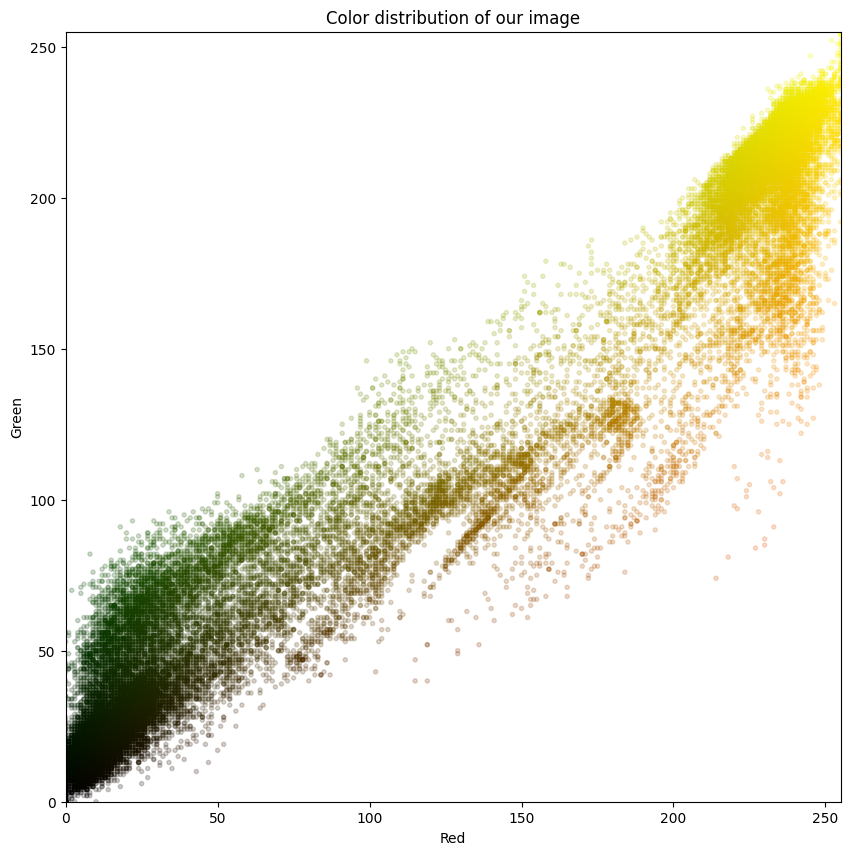

In [6]:
plt.figure(figsize=(10,10))
plot_data(img)

Beautiful, isn't it?

## 2. Create clusters
We will now create clusters of colors.
You know the story now: let us train a "clusterer" to create groups of elements in high density regions.

To facilitate your work, here is a 2-channel version of the image that will ease the training:

In [7]:
img_rg = img[...,:2]
img_rg.shape

(196, 200, 2)

In [16]:
def plot_clusters(X, y=None, /, size=1, label=None):
    '''
    X: 2d points
    y (integers): optionnal label for X samples
    size: point size
    label (str): legend entry
    '''
    plt.scatter(X[:, 0], X[:, 1], c=y, s=size, label=label)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data_centers_assignments(clusterer, X, resolution=1000):
    '''
    clusterer: centroïd-based clustering object, must have a predict() method and a cluster_centers_ attribute.
    X (np.array, 2D): observations to predict classes for
    '''
    testy = clusterer.predict(X)
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plot_clusters(X, size=1, label="data")
    plot_clusters(clusterer.cluster_centers_, np.arange(len(clusterer.cluster_centers_)), 
                  size=100, label="centroids")
    plt.title("Original data and learned cluster centroids.")
    plt.legend()
    plt.subplot(1,2,2)
    plot_clusters(X, testy)
    plt.title("Cluster assignments (recovered).")
    plt.show()

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Using `sklearn.cluster.???`, learn a clustering predictor and predict the cluster ids for each pixel of the image.</b>

<b>Hints</b>
- Use a sane number of clusters (like 16 => 4 bits of data for each color).
- Set the `random_state` parameter for reproducibility.
- Check the clusters centers.
- Predict the ID of the closest cluster center for each pixel (this is called the *label map*). Warning: you will have to reshape the image to match with the input format of the `predict()` method.
- Display this label map. Warning: you will have to reshape the predictions.

</div>

In [66]:
# FIXME
from sklearn.cluster import KMeans
w, h, d = img_rg.shape
img_rg_reshape = np.reshape(img_rg, (w * h, d))
kmeans = KMeans(n_clusters=16, random_state=42)

kmeans.fit(img_rg_reshape)


KMeans(n_clusters=16, random_state=42)

(196, 200)


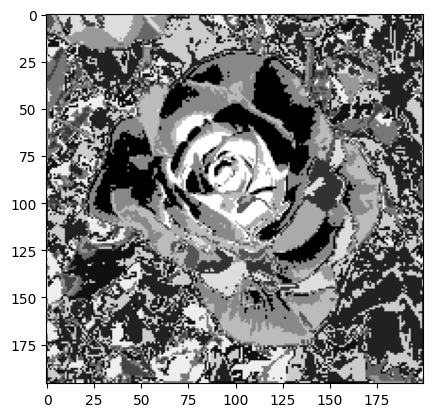

In [67]:
labels = kmeans.predict(img_rg_reshape)
print(img.shape[:2])
plt.imshow(labels.reshape(img.shape[:2]), cmap='gray_r')

### 3. Plot decision boundaries

We can now ask for prediction for a dense sampling of the color space, checking the cluster of each of the color values and the decision boundaries.

In [68]:
def plot_decision_boundaries(clusterer):
    '''Plot the decision boundaries for some clusterer in the [0,255]^2 space.'''
    # Generate grid of points
    xx, yy = np.meshgrid(np.linspace(0,255,1000),
                         np.linspace(0,255,1000))
    # Compute predictions
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot contours
    plt.contour(Z, extent=(0, 255, 0, 255),
                linewidths=1, colors='b', linestyles='dashed',
                alpha=0.5, levels=clusterer.cluster_centers_.shape[0])
    # Plot centroids
    plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],
                marker='o', s=30, linewidths=8,
                color='w', zorder=10, alpha=0.9)
    plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],
                marker='x', s=10, linewidths=10,
                color='k', zorder=11, alpha=1)
    plt.gca().set_aspect("equal")

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Using the previous nice function, and the `plot_data()` function, show the decision boundaries (the Voronoï diagram) of the clustering we learned.</b>

</div>

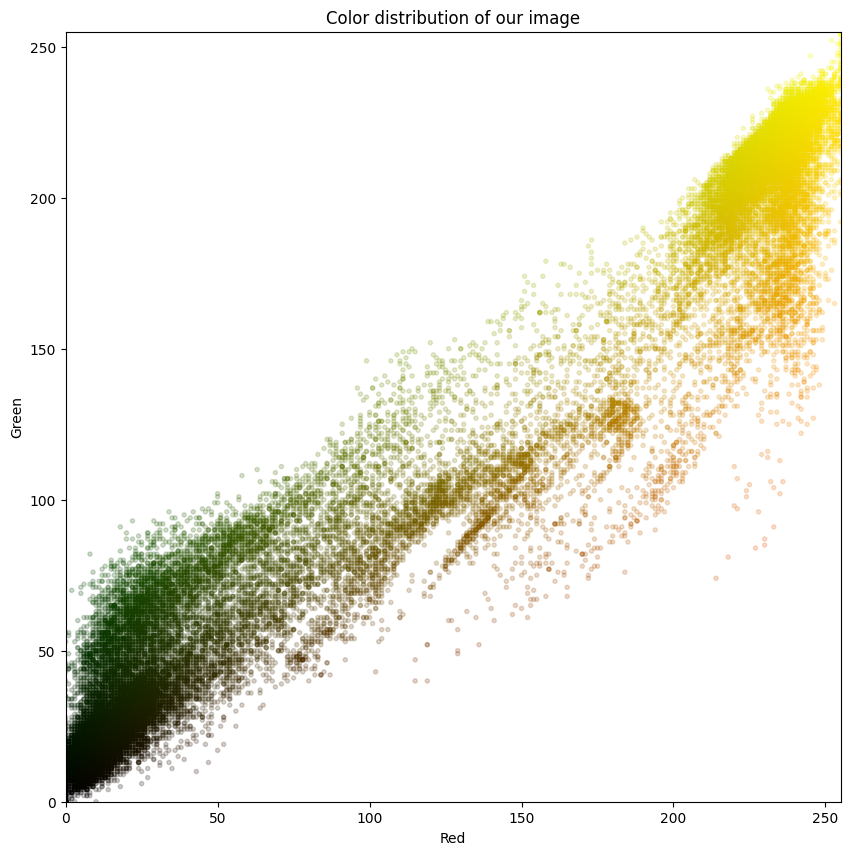

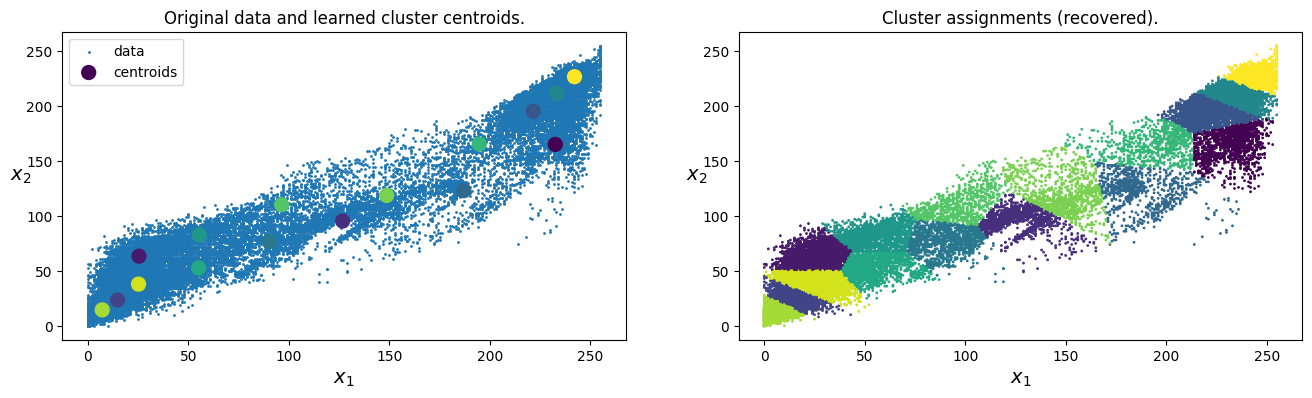

In [69]:
#FIXME
plt.figure(figsize=(10,10))
plot_data(img)
plot_data_centers_assignments(kmeans, img_rg_reshape)

### 4. Show the recolored image
This is the funny part: we need to use the [LUT (LookUp Table)](https://en.wikipedia.org/wiki/Lookup_table) trick so we can assign for each label the color of the associated cluster center.

The LUT is a simple array which contains the color of each cluster center, so that `LUT[0]` contains the RGB color of cluster 0, `LUT[1]` contains the RGB color of cluster 1, and so on.

Once we get this LUT, using it is very simple thanks to Numpy's indexing capabilities: teachers will help you at this point.

The tricky part is to create a LUT from cluster centers which have only red and green color values here (in our particular case); so we need to add an extra channel to the LUT with zero blue values.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Create a `create_lut()` function which creates a RGB LUT from cluster centers.</b>

</div>

In [76]:
def create_lut(clusterer):
    LUT = np.zeros((clusterer.n_clusters, 3), dtype=np.uint8)
    LUT[...,:2] = clusterer.cluster_centers_
    return LUT
    

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Create a `recolor()` function which returns a recolored version of some image using a previously-trained clusterer.</b>

</div>

In [77]:
def recolor(clusterer, img):
    # FIXME
    img_rg = img[...,:2]
    w, h, d = img_rg.shape
    img_rg = np.reshape(img_rg, (w * h, d))
    labels = clusterer.predict(img_rg)
    LUT = create_lut(clusterer)
    recolored = LUT[labels]
    recolored = recolored.reshape(img.shape)
    return recolored

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Finally display our recolored image!</b>

</div>

Text(0.5, 1.0, 'Recolored image (16 colors)')

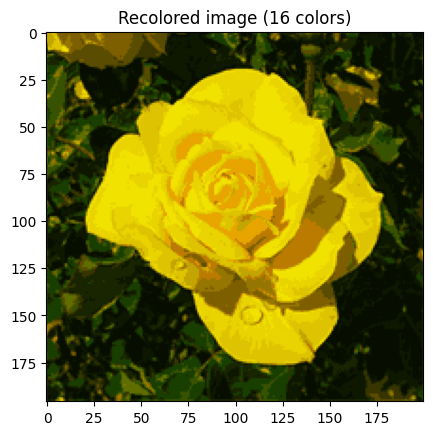

In [81]:
# FIXME
final_img = recolor(kmeans, img)
plt.imshow(final_img)
plt.title("Recolored image (16 colors)")

## 5. Try different palette sizes
We can finally try different palette sizes to look for the best result.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Try different palette sizes using the color quantization pipeline we implemented. Show the results to generate a cool figure like the one in the introduction.</b>

</div>

In [82]:
# TODO
recolored_img = []
n_colors = (8,16,32,64,128)
for k in n_colors:
    print(f"Start {k}")
    clusterer = KMeans(k, random_state=42).fit(img[...,:2].reshape((-1,2)))
    recolored_img.append(recolor(clusterer, img))
    print(f"Done {k}")

Start 8
Done 8
Start 16
Done 16
Start 32
Done 32
Start 64
Done 64
Start 128
Done 128


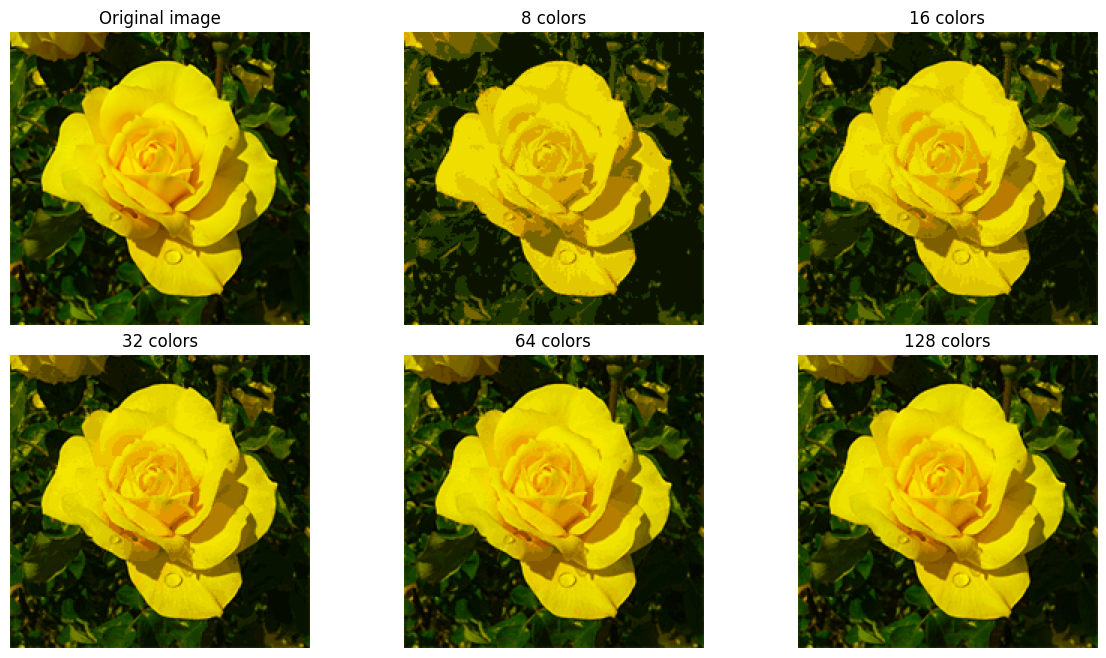

In [83]:
plt.figure(figsize=(15,8))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(img)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(recolored_img[idx])
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

# Going further
[Dithering](https://en.wikipedia.org/wiki/Dither) can be used to improve the visual appearance of color-reduced images (sort of "dot painting").

# Good job!
You are now ready to move on to the next part.